In [70]:
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt

from tqdm import tqdm, trange

In [71]:
from pathlib import Path

DATA_DIR = Path("../data/")

def read_dataset_file(path: Path) -> np.lib.npyio.NpzFile:
    return np.load(file=path, allow_pickle=True)

metr_la = read_dataset_file(DATA_DIR / "metr_la_new.npz")
metr_la

NpzFile '../data/metr_la_new.npz' with keys: num_timestamps, num_nodes, first_timestamp_datetime, last_timestamp_datetime, timestamp_frequency...

In [72]:
metr_la["timestamp_frequency"].item()

datetime.timedelta(seconds=300)

In [73]:
EDGES_KEY = "edges"
TARGETS_KEY = "targets"
SPATIAL_FEATURES_KEY = "spatial_node_features"

In [74]:
metr_la[EDGES_KEY]

array([[  0,  37],
       [  0,  54],
       [  0, 116],
       ...,
       [206, 155],
       [206, 159],
       [206, 163]], dtype=int32)

In [75]:
metr_la

NpzFile '../data/metr_la_new.npz' with keys: num_timestamps, num_nodes, first_timestamp_datetime, last_timestamp_datetime, timestamp_frequency...

In [76]:
metr_la_targets = metr_la[TARGETS_KEY]
metr_la_coords = metr_la[SPATIAL_FEATURES_KEY]
metr_la_targets.shape

(34272, 207)

In [77]:
window_size_1_hr = 12 * 24

kernel_averager = np.ones(window_size_1_hr) / window_size_1_hr
# print(f"{kernel_averager=}")


# 1) NaN - ???? --> replace nans 
# Replace strategies - mean, median, last value, [0 !!!!]

#тут мы решили заполнить нулями nans 
metr_la__targets_transposed = np.nan_to_num(metr_la_targets, 0).T
metr_la__targets_transposed.shape

math_expectation = np.zeros(207)  # expectation OR mean
for i in range(207):
    sum_sensors = 0
    for j in range(metr_la__targets_transposed.shape[1]):  # /// HERE!!!!
        sum_sensors += metr_la__targets_transposed[i][j]
    sum_sensors /= metr_la__targets_transposed.shape[1]
    math_expectation[i] = sum_sensors
math_expectation.shape

(207,)

In [78]:
def get_coverage(array_x: list, array_y: list, x_math: int, y_math: int, count = 207, timestamps_cap = 34272):
    cov = 0
    for i in range(timestamps_cap):
        cov += (array_x[i] - x_math) * (array_y[i] - y_math)
    return cov


In [79]:
print(get_coverage(metr_la__targets_transposed[0], metr_la__targets_transposed[1], math_expectation[0], math_expectation[1]))

7895488.968878485


In [80]:
def get_dispersion(array: list, math_x: int, count = 207, timestamps_cap = 34272):
    dispersion = 0
    for i in range(timestamps_cap):
        dispersion += (array[i] - math_x) ** 2
    return np.sqrt(dispersion)

In [81]:
def get_correlation(array_x: list, array_y: list, x_math: int, y_math: int, count = 207):
    return get_coverage(array_x, array_y, x_math, y_math) / (get_dispersion(array_x, x_math) * get_dispersion(array_y, y_math))

In [82]:
print(get_correlation(metr_la__targets_transposed[0], metr_la__targets_transposed[1], math_expectation[0], math_expectation[1]))

0.6377693185023642


In [83]:
def get_all_correlation(array_x_y: list, array_x_math: list, count = 207):
    ans_matrix = np.zeros((count, count))
    for i in trange(count):
        for j in range(i, count):
            ans_matrix[i, j] = ans_matrix[j, i] = get_correlation(array_x_y[i], array_x_y[j], array_x_math[i], array_x_math[j])
    return ans_matrix

In [111]:
metr_la__targets_transposed.shape

(207, 34272)

In [ ]:
matrix = np.corrcoef(metr_la__targets_transposed[:, 1:], metr_la__targets_transposed[:, :-1])
cnt = 0
for i in range(207):
    for j in range (matrix.shape[1]):
        cnt += (matrix[i][j] >= 0.85)

cnt

46

In [85]:
corrcoeff_ground_truth = np.corrcoef(metr_la__targets_transposed)

In [86]:
np.corrcoef(metr_la__targets_transposed)

array([[1.        , 0.63776932, 0.51020576, ..., 0.56631208, 0.58506304,
        0.48917555],
       [0.63776932, 1.        , 0.84697142, ..., 0.86088827, 0.80049981,
        0.62187005],
       [0.51020576, 0.84697142, 1.        , ..., 0.8705897 , 0.67544606,
        0.57938259],
       ...,
       [0.56631208, 0.86088827, 0.8705897 , ..., 1.        , 0.73088846,
        0.66675078],
       [0.58506304, 0.80049981, 0.67544606, ..., 0.73088846, 1.        ,
        0.59488127],
       [0.48917555, 0.62187005, 0.57938259, ..., 0.66675078, 0.59488127,
        1.        ]])

In [87]:
graph = metr_la[EDGES_KEY]
graph[10]

array([2, 1], dtype=int32)

In [88]:
matrix

array([[1.        , 0.63776728, 0.51020366, ..., 0.54395156, 0.56119535,
        0.47346404],
       [0.63776728, 1.        , 0.84697084, ..., 0.82063169, 0.76128879,
        0.59196452],
       [0.51020366, 0.84697084, 1.        , ..., 0.8334544 , 0.64120327,
        0.54983841],
       ...,
       [0.54395156, 0.82063169, 0.8334544 , ..., 1.        , 0.73088629,
        0.66674817],
       [0.56119535, 0.76128879, 0.64120327, ..., 0.73088629, 1.        ,
        0.59487826],
       [0.47346404, 0.59196452, 0.54983841, ..., 0.66674817, 0.59487826,
        1.        ]])

In [89]:
graph_in_matrix = np.zeros((207, 207))
for edge in graph:
    graph_in_matrix[edge[0], edge[1]] = 1

In [90]:
graph_in_matrix # рисуем матрицу смежности

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
correlations_with_edges = np.zeros((207, 207))
for i in range(len(graph_in_matrix)):
    for j in range(len(graph_in_matrix[0])):
        correlations_with_edges[i][j] = graph_in_matrix[i][j] * matrix[i][j]
correlations_with_edges # корреляции только для ребер графа

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.84697084, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.84697084, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

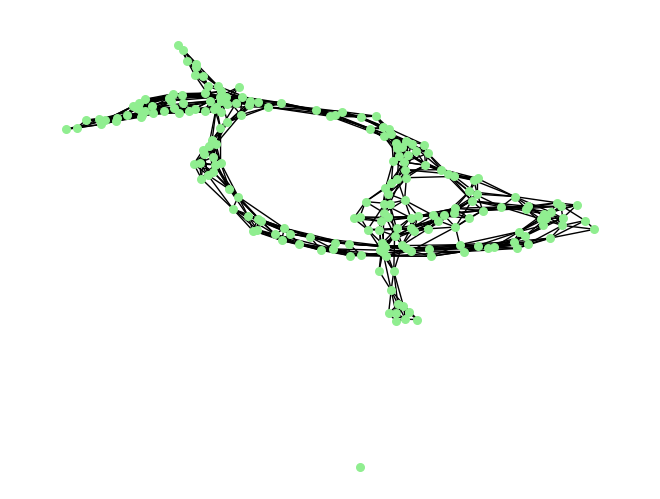

In [92]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# Создание графа
G = nx.from_numpy_array(graph_in_matrix)

# Рисование графа
nx.draw(G, with_labels=False, node_size=30, node_color='lightgreen', node_shape='o', font_size=5)
plt.show()

In [93]:
!pip install folium


[notice] A new release of pip available: 22.3 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [94]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[34.052235, -118.243683],
               zoom_start=11,
               tiles='cartodbpositron')

metr_la_targets = metr_la[TARGETS_KEY]
metr_la_targets

array([[64.375   , 67.625   , 67.125   , ..., 59.25    , 69.      ,
        61.875   ],
       [62.666668, 68.55556 , 65.44444 , ..., 55.88889 , 68.44444 ,
        62.875   ],
       [64.      , 63.75    , 60.      , ..., 61.375   , 69.85714 ,
        62.      ],
       ...,
       [67.      , 59.666668, 69.55556 , ..., 63.333332, 67.44444 ,
        61.22222 ],
       [66.75    , 62.25    , 66.      , ..., 63.      , 67.875   ,
        63.5     ],
       [65.111115, 66.888885, 66.77778 , ..., 63.555557, 68.666664,
        61.77778 ]], dtype=float32)

In [95]:
timestamps = pd.date_range(start=metr_la["first_timestamp_datetime"].item(),
                           end=metr_la["last_timestamp_datetime"].item(),
                           freq="5min",
                           )
timestamps

DatetimeIndex(['2012-03-01 00:00:00', '2012-03-01 00:05:00',
               '2012-03-01 00:10:00', '2012-03-01 00:15:00',
               '2012-03-01 00:20:00', '2012-03-01 00:25:00',
               '2012-03-01 00:30:00', '2012-03-01 00:35:00',
               '2012-03-01 00:40:00', '2012-03-01 00:45:00',
               ...
               '2012-06-27 23:10:00', '2012-06-27 23:15:00',
               '2012-06-27 23:20:00', '2012-06-27 23:25:00',
               '2012-06-27 23:30:00', '2012-06-27 23:35:00',
               '2012-06-27 23:40:00', '2012-06-27 23:45:00',
               '2012-06-27 23:50:00', '2012-06-27 23:55:00'],
              dtype='datetime64[ns]', length=34272, freq='5T')

In [96]:
time_ = 0
metr_la_coords = metr_la[SPATIAL_FEATURES_KEY]

metr_la_coords[0]

get_node = {}
for i in range(len(metr_la_coords[0])):
    get_node[tuple(metr_la_coords[0][i])] = i
get_node

{(34.15497, -118.31829): 0,
 (34.11621, -118.23799): 1,
 (34.11641, -118.23819): 2,
 (34.07248, -118.26772): 3,
 (34.07142, -118.26572): 4,
 (34.06913, -118.25932): 5,
 (34.05368, -118.23369): 6,
 (34.13486, -118.22932): 7,
 (34.20264, -118.47352): 8,
 (34.15562, -118.4686): 9,
 (34.16415, -118.38223): 10,
 (34.15691, -118.22469): 11,
 (34.07821, -118.28795): 12,
 (34.1566, -118.30266): 13,
 (34.18949, -118.47437): 14,
 (34.07006, -118.26246): 15,
 (34.07314, -118.23388): 16,
 (34.07732, -118.28186): 17,
 (34.20672, -118.19992): 18,
 (34.12095, -118.33911): 19,
 (34.12073, -118.33928): 20,
 (34.20584, -118.19803): 21,
 (34.12634, -118.34482): 22,
 (34.05767, -118.21435): 23,
 (34.15478, -118.27076): 24,
 (34.12121, -118.27164): 25,
 (34.09478, -118.47605): 26,
 (34.12967, -118.22871): 27,
 (34.12964, -118.22901): 28,
 (34.0839, -118.22086): 29,
 (34.08374, -118.22076): 30,
 (34.17878, -118.39469): 31,
 (34.11027, -118.33441): 32,
 (34.06664, -118.25397): 33,
 (34.18784, -118.47407): 34

In [97]:
df = pd.DataFrame(metr_la_coords[0], columns=['latitude', 'longitude'])
#HeatMap(df, radius=10).add_to(m)

In [98]:
m

In [99]:
!pip install osmnx
!pip install shapely
import shapely
import osmnx
from shapely.geometry import Point, Polygon, LineString
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, GeometryCollection, LineString
import json
multipoints = MultiPoint([[a, b] for a, b in metr_la_coords[0]])
geojson = shapely.geometry.mapping(multipoints)
geojson


[notice] A new release of pip available: 22.3 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 25.0
[notice] To update, run: pip install --upgrade pip


{'type': 'MultiPoint',
 'coordinates': ((34.15496826171875, -118.31829071044922),
  (34.1162109375, -118.23799133300781),
  (34.11640930175781, -118.23818969726562),
  (34.072479248046875, -118.2677230834961),
  (34.07141876220703, -118.26571655273438),
  (34.069129943847656, -118.25932312011719),
  (34.053680419921875, -118.23368835449219),
  (34.13486099243164, -118.22931671142578),
  (34.202640533447266, -118.47351837158203),
  (34.15562057495117, -118.46859741210938),
  (34.16415023803711, -118.38223266601562),
  (34.15690994262695, -118.22469329833984),
  (34.078208923339844, -118.28794860839844),
  (34.15660095214844, -118.30265808105469),
  (34.189491271972656, -118.47437286376953),
  (34.07006072998047, -118.26245880126953),
  (34.07313919067383, -118.23387908935547),
  (34.07732009887695, -118.2818603515625),
  (34.20671844482422, -118.19992065429688),
  (34.120948791503906, -118.339111328125),
  (34.120731353759766, -118.33927917480469),
  (34.205841064453125, -118.1980285644

In [100]:
import colorsys

In [101]:
time = 18*12 + 288 * 6
for i, point in enumerate(geojson['coordinates']):
    normal_vel = (metr_la_targets[time, i]) / 75
    folium.CircleMarker(list(point), radius=2, fill=True, color='green', fill_color='green', fill_opacity=0.3).add_to(m)
    #folium.PolyLine([[G.nodes[edge[0]]['lat'], G.nodes[edge[0]]['lon']], [G.nodes[edge[1]]['lat'], G.nodes[edge[1]]['lon']]], color=color).add_to(m)

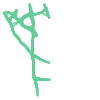

In [102]:
metr_la_edges = metr_la[EDGES_KEY]
metr_la_edges
multiline = MultiLineString([LineString([Point(metr_la_coords[0][start]), Point(metr_la_coords[0][end])])
                            for start, end in metr_la_edges])
multiline

In [103]:
geojson_line = shapely.geometry.mapping(multiline)
geojson_line

{'type': 'MultiLineString',
 'coordinates': (((34.15496826171875, -118.31829071044922),
   (34.15541076660156, -118.2957534790039)),
  ((34.15496826171875, -118.31829071044922),
   (34.15522003173828, -118.29344177246094)),
  ((34.15496826171875, -118.31829071044922),
   (34.15351104736328, -118.32750701904297)),
  ((34.15496826171875, -118.31829071044922),
   (34.156410217285156, -118.30265808105469)),
  ((34.15496826171875, -118.31829071044922),
   (34.155460357666016, -118.30841064453125)),
  ((34.1162109375, -118.23799133300781),
   (34.11640930175781, -118.23818969726562)),
  ((34.1162109375, -118.23799133300781),
   (34.13486099243164, -118.22931671142578)),
  ((34.1162109375, -118.23799133300781),
   (34.129638671875, -118.22901153564453)),
  ((34.1162109375, -118.23799133300781),
   (34.11296081542969, -118.24488830566406)),
  ((34.1162109375, -118.23799133300781),
   (34.119659423828125, -118.23143005371094)),
  ((34.11640930175781, -118.23818969726562),
   (34.1162109375, -11

In [104]:
for line in geojson_line['coordinates']:
    first_node = get_node[tuple(line[0])]
    second_node = get_node[tuple(line[1])]
    hue = matrix[first_node][second_node]
    print(hue)
    #color = colorsys.hsv_to_rgb(1,1,(hue + 0.5)/1.5)
    #color = '#{:02x}{:02x}{:02x}'.format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
    #folium.PolyLine([list(line[0]), list(line[1])], color = color, opacity= hue / 10).add_to(m)
    hue = (hue + 1) / 3.4  # нормализация веса от -1 до 1 к диапазону от 0 до 1
    if hue < 0.5:
        color = "green"  # зеленый градиент
        opacity_coef = 3
    else:
        color = 'red'
        opacity_coef = 4

    folium.PolyLine([list(line[0]), list(line[1])], color = color, opacity=hue / opacity_coef).add_to(m)
m

0.8459851408315998
0.7236178500451148
0.6665345325876737
0.6791796350889722
0.7563882887260213
0.8469708386064922
0.7877055641746276
0.8482599717582769
0.8192886100907455
0.9647654870847785
0.8469708386064922
0.7081980302472196
0.9717318170621642
0.8308838481543144
0.9185310704954616
0.7365292532576829
0.75073857073276
0.9353703351086966
0.9018863949304089
0.9697524879040974
0.7365292532576829
0.960423971511545
0.8439683366344077
0.8171054956884645
0.7067079690661722
0.8892561671728256
0.6351514923537478
0.8515042838518221
0.7664206807763027
0.8773039439908429
0.6830617750230732
0.9386551381909314
0.7582790022672125
0.8630662410245917
0.4895611227531027
0.9318210095559686
0.9412268978795797
0.6956489716037582
0.7438570508774361
0.5906426999582441
0.8512619997459854
0.7759759350857872
0.8212552365559489
0.8965037188238497
0.9452226737849484
0.4512527981190219
0.5653420917765881
0.4073171270842355
0.42209888962809633
0.33681548607997486
0.8249641844949508
0.7120680052415592
0.71028816628

In [105]:
import plotly.express as px

In [106]:
px.imshow(matrix)

In [107]:
px.imshow(correlations_with_edges)

###   Задача: вычленить из графа "лишние ребра", убрав те из них, которые не соответствуют дорогам

In [108]:
correlations_with_edges # это прореженный по корреляциям граф

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.84697084, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.84697084, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [109]:
edges_count = 0

for i in range(len(gragh_in_matrix)):
    for j in range(len(graph_in_matrix[0])):
        edges_count += graph_in_matrix[i][j]
print(f"рёбер {edges_count}")
print(correlations_with_edges.shape)
def how_many_low_correlations(alpha): 
    low_correlations = 0
    for i in range(len(correlations_with_edges)):
        for j in range(len(correlations_with_edges[0])):
            if (correlations_with_edges[i][j]) < alpha and correlations_with_edges[i][j] > 0:
                low_correlations += 1
    low_correlations
    #print(f"корреляций {low_correlations}")
    percent_of_low_correlations = 100.0 * low_correlations / edges_count
    #print(f"в процентах это {percent_of_low_correlations}")
    return low_correlations

NameError: name 'gragh_in_matrix' is not defined

In [ ]:
import plotly.graph_objs as go

In [ ]:
x = np.linspace(0, 1, 4000)
y = [how_many_low_correlations(alpha) for alpha in x]

# Построение графика
fig = go.Figure(data=[go.Scatter(x=x, y=y, name = "график")])
fig.update_layout(xaxis=dict(tick0=-10, dtick=0.1))
fig.update_layout(yaxis=dict(tick0=0, dtick=100))
fig.update_layout(title='We are looking for the optimal coefficient to eliminate most low correlations', xaxis_title='minimum lower bound for correlation', yaxis_title='number of correlations')
fig.add_trace(go.Scatter(x=[0.5], y=[56], mode='markers', marker=dict(color='red', size=7), name = "≈ 8% correlations"))
fig.add_trace(go.Scatter(x=[0.6], y=[190], mode='markers', marker=dict(color='green', size=7), name = "≈ 20% correlations"))
# Отображаем координаты точки
fig.update_layout(
    xaxis=dict(hoverformat='.2f'),
    yaxis=dict(hoverformat='.2f')
)
fig.show()

NameError: name 'how_many_low_correlations' is not defined